In [40]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
class PINN(nn.Module):
    def __init__(self, layers=[2, 50, 50, 1]):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-2):
            self.net.add_module(f"fc{i}", nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f"tanh{i}", nn.Tanh())
        self.net.add_module("output", nn.Linear(layers[-2], layers[-1]))

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

# 2. Save the model
torch.save(model.state_dict(), "pinn_klein_gordon.pth")

# 3. Load the model
model = PINN().to(device)
model.load_state_dict(torch.load("pinn_klein_gordon.pth"))
model.eval()

/var/folders/hq/bybqbzn50nn7r92k75l7tr440000gn/T/ipykernel_2200/186012741.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pinn_klein_g

PINN(
  (net): Sequential(
    (fc0): Linear(in_features=2, out_features=50, bias=True)
    (tanh0): Tanh()
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (tanh1): Tanh()
    (output): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [42]:
def pde_residual(model, x, t, m=1.0):
    x.requires_grad = True
    t.requires_grad = True
    phi = model(x, t)

    phi_t = autograd.grad(phi, t, grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_tt = autograd.grad(phi_t, t, grad_outputs=torch.ones_like(phi_t), create_graph=True)[0]
    phi_x = autograd.grad(phi, x, grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_xx = autograd.grad(phi_x, x, grad_outputs=torch.ones_like(phi_x), create_graph=True)[0]

    return phi_tt - phi_xx + m**2 * phi

In [43]:
def initial_condition(x):
    return torch.sin(np.pi * x)

def initial_velocity(x):
    return torch.zeros_like(x)

def boundary_condition(t):
    return torch.zeros_like(t)

In [44]:
def train_model(num_epochs=5000, lr=1e-3):
    model = PINN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs + 1):
        optimizer.zero_grad()

        # Collocation Points
        x_colloc = torch.rand((500, 1)) * 2 - 1  # [-1, 1]
        t_colloc = torch.rand((500, 1))          # [0, 1]
        x_colloc = x_colloc.to(device)
        t_colloc = t_colloc.to(device)
        loss_pde = torch.mean(pde_residual(model, x_colloc, t_colloc) ** 2)

        # Initial Conditions
        x_init = torch.linspace(-1, 1, 100).reshape(-1, 1).to(device)
        t_zero = torch.zeros_like(x_init).to(device).requires_grad_(True)

        phi_pred_init = model(x_init, t_zero)
        loss_ic = torch.mean((phi_pred_init - initial_condition(x_init))**2)

        # Initial Velocity Condition
        phi_t = autograd.grad(phi_pred_init, t_zero, grad_outputs=torch.ones_like(phi_pred_init), create_graph=True)[0]
        loss_ic_vel = torch.mean((phi_t - initial_velocity(x_init))**2)

        # Boundary Condition
        t_bc = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
        x_left = -1 * torch.ones_like(t_bc).to(device)
        x_right = 1 * torch.ones_like(t_bc).to(device)

        loss_bc = torch.mean(model(x_left, t_bc)**2) + torch.mean(model(x_right, t_bc)**2)

        # Total loss
        loss = loss_pde + loss_ic + loss_ic_vel + loss_bc
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    return model

In [45]:
model = train_model()

Epoch 0: Loss = 1.021786
Epoch 500: Loss = 0.108762
Epoch 1000: Loss = 0.051622
Epoch 1500: Loss = 0.005540
Epoch 2000: Loss = 0.001352
Epoch 2500: Loss = 0.001159
Epoch 3000: Loss = 0.000748
Epoch 3500: Loss = 0.000547
Epoch 4000: Loss = 0.000421
Epoch 4500: Loss = 0.000356
Epoch 5000: Loss = 0.000418


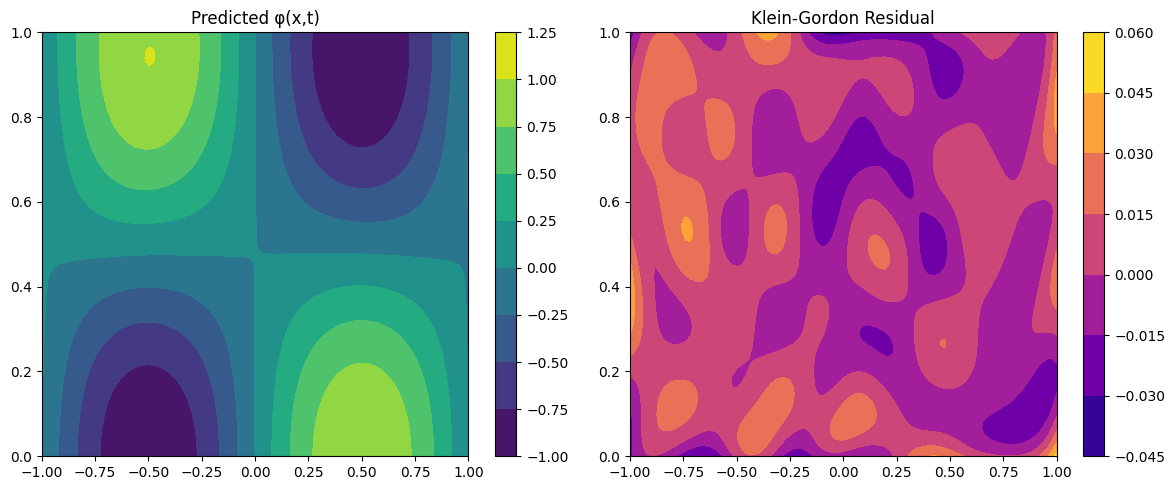

In [46]:
# Prepare plotting grid
x_plot = torch.linspace(-1, 1, 100).reshape(-1, 1).to(device)
t_plot = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
X_plot, T_plot = torch.meshgrid(x_plot.squeeze(), t_plot.squeeze(), indexing="ij")
X_flat = X_plot.reshape(-1, 1).to(device)
T_flat = T_plot.reshape(-1, 1).to(device)

# Compute predicted φ(x, t)
with torch.no_grad():
    phi_pred = model(X_flat, T_flat).reshape(100, 100).cpu()

# Compute residuals (requires gradients, so NOT inside no_grad)
residuals = pde_residual(model, X_flat, T_flat).detach().reshape(100, 100).cpu()

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Predicted φ(x,t)")
plt.contourf(X_plot.cpu(), T_plot.cpu(), phi_pred, cmap="viridis")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Klein-Gordon Residual")
plt.contourf(X_plot.cpu(), T_plot.cpu(), residuals, cmap="plasma")
plt.colorbar()

plt.tight_layout()
plt.show()

In [47]:
residual_np = residuals.cpu().numpy()

print("Residual Mean:", residual_np.mean())
print("Residual Std Dev:", residual_np.std())
print("Residual Max:", residual_np.max())

Residual Mean: 0.0014914803
Residual Std Dev: 0.011403918
Residual Max: 0.051533096


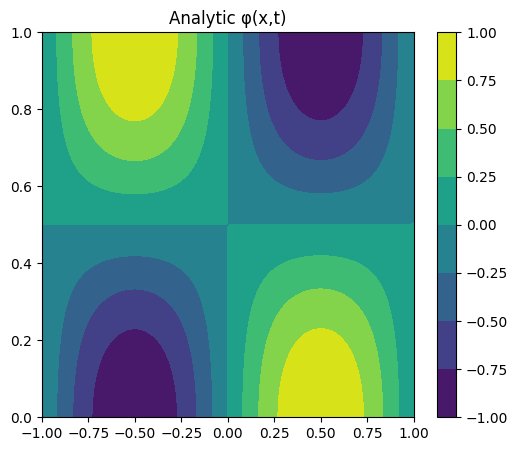

In [48]:
# Example analytic: φ(x, t) = sin(πx) * cos(πt) when m=0
phi_true = torch.sin(np.pi * X_plot) * torch.cos(np.pi * T_plot)

plt.figure(figsize=(6,5))
plt.title("Analytic φ(x,t)")
plt.contourf(X_plot.cpu(), T_plot.cpu(), phi_true, cmap="viridis")
plt.colorbar()
plt.show()

In [49]:
def analytic_solution(x, t):
    return torch.sin(np.pi * x) * torch.cos(np.pi * t)

In [50]:
x_plot = torch.linspace(-1, 1, 100).reshape(-1, 1).to(device)
t_plot = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
X_plot, T_plot = torch.meshgrid(x_plot.squeeze(), t_plot.squeeze(), indexing="ij")

X_flat = X_plot.reshape(-1, 1)
T_flat = T_plot.reshape(-1, 1)

In [51]:
with torch.no_grad():
    phi_pred = model(X_flat, T_flat).reshape(100, 100).cpu()
    phi_true = analytic_solution(X_flat, T_flat).reshape(100, 100).cpu()

In [52]:
error = phi_pred - phi_true
mse = torch.mean(error ** 2).item()
l2_norm = torch.sqrt(torch.mean(error ** 2)).item()

print(f"Mean Squared Error: {mse:.6f}")
print(f"L2 Norm of Error: {l2_norm:.6f}")

Mean Squared Error: 0.001970
L2 Norm of Error: 0.044385


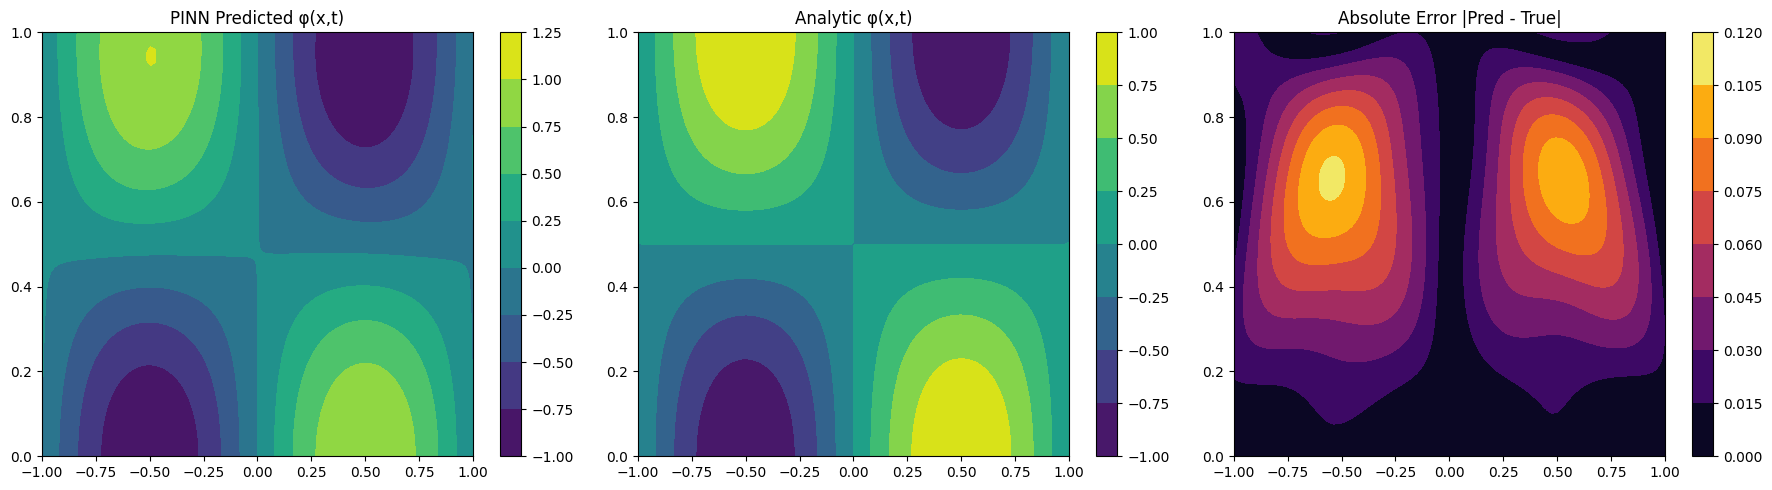

In [53]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("PINN Predicted φ(x,t)")
plt.contourf(X_plot.cpu(), T_plot.cpu(), phi_pred, cmap="viridis")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Analytic φ(x,t)")
plt.contourf(X_plot.cpu(), T_plot.cpu(), phi_true, cmap="viridis")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Absolute Error |Pred - True|")
plt.contourf(X_plot.cpu(), T_plot.cpu(), torch.abs(error), cmap="inferno")
plt.colorbar()

plt.tight_layout()
plt.show()

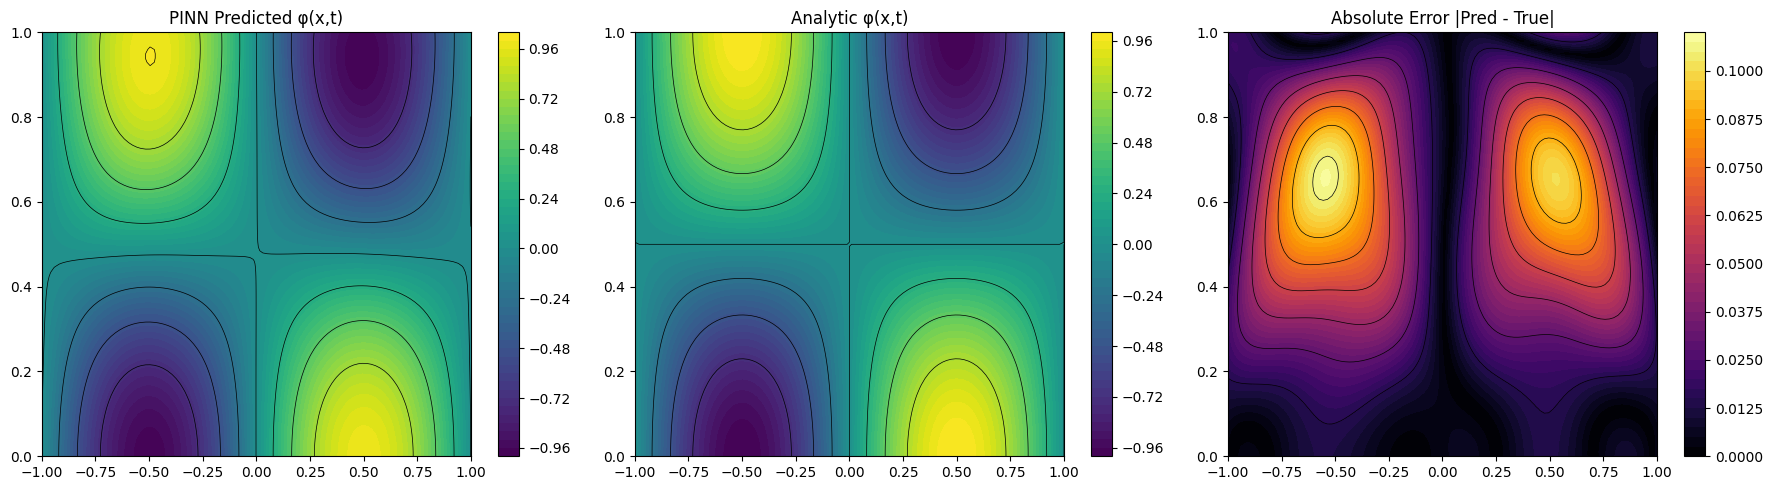

In [55]:
import matplotlib.pyplot as plt

with torch.no_grad():
    phi_pred = model(X_flat, T_flat).reshape(100, 100).cpu()
    
residuals = pde_residual(model, X_flat, T_flat).detach().reshape(100, 100).cpu()

phi_true = torch.sin(np.pi * X_plot) * torch.cos(np.pi * T_plot)

abs_error = torch.abs(phi_pred - phi_true)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("PINN Predicted φ(x,t)")
cont1 = plt.contourf(X_plot.cpu(), T_plot.cpu(), phi_pred, cmap="viridis", levels=50)
plt.contour(X_plot.cpu(), T_plot.cpu(), phi_pred, colors='black', linewidths=0.5, linestyles='solid')
plt.colorbar(cont1)

plt.subplot(1, 3, 2)
plt.title("Analytic φ(x,t)")
cont2 = plt.contourf(X_plot.cpu(), T_plot.cpu(), phi_true, cmap="viridis", levels=50)
plt.contour(X_plot.cpu(), T_plot.cpu(), phi_true, colors='black', linewidths=0.5, linestyles='solid')
plt.colorbar(cont2)

plt.subplot(1, 3, 3)
plt.title("Absolute Error |Pred - True|")
cont3 = plt.contourf(X_plot.cpu(), T_plot.cpu(), abs_error, cmap="inferno", levels=50)
plt.contour(X_plot.cpu(), T_plot.cpu(), abs_error, colors='black', linewidths=0.5, linestyles='solid')
plt.colorbar(cont3)

plt.tight_layout()
plt.show()